In [142]:
import os
import json
import time
import datetime as dt
import numpy as np
import pandas as pd
import factoroid as fr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

WebSQL = fr.connector.MySQLDB('db-01')
DevSQL = fr.connector.MySQLDB('db-dev')

Successfully connected; Factorid web services
Successfully connected; Factoroid development


In [143]:
from model.utils_function import *
from model.utils_cycle import *
from model.utils_output import *
from model.utils_main import *
from model.utils_preprocessor import *

In [157]:
now = dt.datetime(2022, 4, 6, 8)
# now = dt.datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)
# now = now - dt.timedelta(days=2) if now.weekday() == 0 else now
print(now)

2022-04-06 08:00:00


In [158]:
str_datetime = str(now.date())
if not os.path.exists(f'./result/{str_datetime}'):
    os.mkdir(f'./result/{str_datetime}')

In [159]:
# SO data load
# SO data merge

so = pd.DataFrame(WebSQL.query(f'''
                                    SELECT stop.equipment_name AS equipment_name, stop.order_number AS so, stop.gop AS gop, stop.material AS material, stop.qty AS qty, start.report_date AS start_time, MAX(stop.report_date) AS stop_time
                                    FROM so_log_yulkok AS stop
                                    LEFT JOIN (SELECT equipment_name, order_number, gop, material, qty, MIN(report_date) AS report_date
                                            FROM so_log_yulkok
                                            WHERE equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                     'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                     'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                            AND status = '보고시작' AND report_date >= '{str(now - dt.timedelta(days=7))}' AND report_date <= '{str(now)}'
                                            GROUP BY equipment_name, order_number, gop, material, qty) AS start
                                            ON stop.equipment_name = start.equipment_name AND stop.order_number = start.order_number AND stop.gop = start.gop AND stop.material = start.material AND stop.qty = start.qty
                                    WHERE stop.equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                  'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                  'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                    AND stop.status = '보고완료' AND stop.completion_flag = 'X' AND stop.report_date >= '{str(now - dt.timedelta(days=1))}' AND stop.report_date < '{str(now)}'
                                    GROUP BY equipment_name, so, gop, material, qty;
                                '''), columns=['equipment_name', 'so', 'gop', 'material', 'qty', 'start_time', 'stop_time', 'total_runtime'])

so.total_runtime = round((so.stop_time - so.start_time) / np.timedelta64(1,'h'), 3)
so = so.dropna().sort_values(by=['equipment_name', 'start_time']).reset_index(drop=True)

In [160]:
cycle_summary = pd.DataFrame(columns=['factory_id', 'process_id', 'equipment_id', 'equipment_name', 
                                      'material', 'so', 'gop', 'qty', 'cycle_number', 'start_time', 'stop_time',
                                      'spindle', 'idle_inter', 'total'])

In [161]:
so_g = so.groupby(['equipment_name'])
so_g_keys = list(so_g.groups.keys())
if not so_g_keys:
    print('Not found SO data')
else:
    print(f'\nSO data length: {so.shape[0]}\n{", ".join(so_g_keys)}\n')

for machine in so_g_keys:
    so_df_ = so_g.get_group(machine).reset_index(drop=True)
    so_df_ = so_df_[so_df_.total_runtime > 0.1]
    print(f'{machine}: {so_df_.shape[0]}')


SO data length: 69
CMI 3S #8, DMC60T#3, DMU 50 3rd Generation #2, ECOSPEED F1040 #2, G3020 #1, H5-800, HFP1540 PROTO, HU80A-5X, SB-416, SNK RB-200F(2060), VMP8-6P

CMI 3S #8: 2
DMC60T#3: 3
DMU 50 3rd Generation #2: 1
ECOSPEED F1040 #2: 8
G3020 #1: 2
H5-800: 1
HFP1540 PROTO: 2
HU80A-5X: 1
SB-416: 38
SNK RB-200F(2060): 3
VMP8-6P: 5


In [162]:
machine = 'G3020 #1'
so_df_ = so_g.get_group(machine).reset_index(drop=True)
so_df_ = so_df_[so_df_.total_runtime > 0.1]
stop_times = list(so_df_.stop_time.values)
print(machine)
print(f'DataFrame Length: {so_df_.shape[0]}')
so_df_

G3020 #1
DataFrame Length: 2


,equipment_name,so,gop,material,qty,start_time,stop_time,total_runtime
0,G3020 #1,D200592080,30,30P176101200-001A,3,2022-04-05 05:04:57,2022-04-05 14:38:10,9.554
1,G3020 #1,D200592130,30,30P176101200-001A,5,2022-04-05 14:38:22,2022-04-06 05:40:18,15.032


In [181]:
# index_, plotting, company = 0, True, 'yg'
plotting, company = True, 'yg'
config.plot = plotting
config.company = company

for idx_, so_ in so_df_[1:].iterrows():
    
    ######################
    ### read parameter ###
    ######################

    order_number_, gop_, material_, quantity_, so_time_ = so_.so, so_.gop, so_.material, int(so_.qty), so_.total_runtime
    parameter, gap, threshold, min_threshold, smooth_factor, step, upper_limit, mac_main, window, max_cycle, idle_value = params(machine)
    # so_range = [so_.start_time, so_.stop_time]
    # so_range = [pd.to_datetime('2022-04-05 14:30:22'), pd.to_datetime('2022-04-06 05:38:18')]
    
    # print(f'''
    # {'='*100}
    # index: {idx_},\t{order_number_}\t{gop_}\t{material_}\t{quantity_}      {so_.start_time} ~ {so_.stop_time}
    # {'='*100}
    # ''')

    print(f'''
OrderNumber\tGOP\tMaterial\t\tQuantity\tStart ~ End
{'='*105}
{order_number_}\t{gop_}\t{material_}\t{quantity_}\t\t{so_.start_time} ~ {so_.stop_time}
{'='*105}
    ''')

    # exchange padded time
    so_range = [so_.start_time, so_.stop_time]
    padded_time = so_time_*0.2 if ((so_time_ / quantity_) >= 1) or (quantity_ > 1) else so_time_*0.5

    ########################
    ### define timeRange ###
    ########################

    timeWindowRedefine = False
    while True:
        patterns, candidates, pattern_index, start_time, _, lll, _ = pattern_history_parse(machine, order_number_)
        # print(patterns)
        if timeWindowRedefine == False: pass
        else:
            print(f"Current time window of interest: {str(so_range[0])} ~ {str(so_range[1])}")
            time.sleep(1)
            start_ = input("Proposed new SO start datetime (format: YYYY-MM-DD HH:MM:SS): ")
            stop_ = input("Proposed new SO stop datetime (format: YYYY-MM-DD HH:MM:SS): ")
            so_range = [pd.to_datetime(start_), pd.to_datetime(stop_)]
            
        padded_range = [so_range[0] - dt.timedelta(hours=padded_time), so_range[1] + dt.timedelta(hours=padded_time)]
        plot_start_time = str(padded_range[0])
        plot_stop_time = str(stop_times[idx_+1]).replace("T", " ")[:19] if stop_times[idx_+1:idx_+2] and so_.stop_time not in stop_times[idx_+1:] else str(padded_range[1])
        period_ = fr.utils.Period([plot_start_time, plot_stop_time])

        row = WebSQL.get_data(mac=mac_main, period=period_.utc)
        data_ = fr.processor.preprocess(row)
        # data_ = signal_preprocessing(data_)
        next_data, current_data = data_[data_.timestamp > so_range[1]], data_[data_.timestamp <= so_range[1]]

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=next_data.timestamp, y=next_data.value, mode='lines', line=dict(width=2, color='#1f77b4'), opacity=0.4, name='next SO', showlegend=True))
        fig.add_trace(go.Scatter(x=current_data.timestamp, y=current_data.value, mode='lines', line=dict(width=3, color='#1f77b4'), opacity=1.0, name='current data', showlegend=True))
        fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
        fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=300, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation='h', yanchor='bottom', y=1.04, xanchor='left', x=0))
        fig.show()
        time.sleep(2)

        proceed = input("Do we need to change time window to detect at least one complete cycle? (Y/N): ")
        if proceed == "N":
            break
        timeWindowRedefine = True

    # temp dataRange, [padded_range[0], so_range[1]]
    # temp = data_[(data_.timestamp > plot_start_time) & (data_.timestamp <= so_range[1])]
    # so_range = [pd.to_datetime('2022-04-05 13:40:00'), pd.to_datetime('2022-04-06 05:40:00')]
    temp = data_[(data_.timestamp > so_range[0]) & (data_.timestamp <= so_range[1])]
    temp = data_[(data_.timestamp > plot_start_time) & (data_.timestamp <= so_range[1])]
    
    # cleaning + smoothing + inactive phase detection
    times_, y_ = cleaning(temp, smooth_factor, min_threshold)
    smooth_ = smoothing(y_, step)
    times, ss, inactive_cycles_ = inactive_phase_cleaning_normalization(smooth_, times_, upper_limit, window, so_range)

    # active phase detection
    cycles_ = active_phase(ss, times, threshold, upper_limit, max_cycle * 60, gap, idle_value)
    cycles = cycle_generate(cycles_, times, ss, inactive_cycles_, so_range)

    ###############################
    ### define machineParameter ###
    ###############################

    parameterRedefine = False
    while True:
        if parameterRedefine == False: pass
        else:
            times, ss, cycles = params_redefine(temp, machine, so_range)
            parameter, gap, threshold, min_threshold, smooth_factor, step, upper_limit, mac_main, window, max_cycle, idle_value = params(machine)
            print('Parameter Redefine')
        
        active_phase_idx = 0
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=pd.to_datetime(times), y=ss, mode='lines', opacity=0.3, name='smooth', showlegend=False))
        for _, c in enumerate(cycles):
            xx, yy = pd.to_datetime([aa[0] for aa in c]), [aa[1] for aa in c]
            center_idx, max_yy = int(len(xx)//2), max(yy)
            fig.add_trace(go.Scatter(x=xx, y=yy, mode='lines', name=f'{active_phase_idx}', line=dict(width=3)))
            fig.add_trace(go.Scatter(x=[xx[center_idx]], y=[max_yy*1.1], mode='markers+text', text=f'{active_phase_idx}',
                            textposition='middle center', textfont=dict(family='bold', color='black'),
                            marker=dict(color='gray',opacity=0.2,size=15, line=dict(color='black', width=2)), showlegend=False))
            active_phase_idx += 1
        fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
        fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2))
        fig.show()
        time.sleep(2)
        
        proceed = input("Do we need to change parameter to detect at least one complete cycle? (Y/N): ")
        if proceed == "N":
            break
        parameterRedefine = True

    # cycle parameter
    cycle_parameter = parameter[machine]['cycle']
    # cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 else 1000
    cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 and machine not in ['SNK RB-200F(2060)'] else 1000
    cycle_parameter['min_dist'] = round(max(cycle_parameter['lower_limit'] ** 0.4, 2.8), 1) * 1.3
    cycle_parameter['order'] = int(min(max(cycle_parameter['lower_limit'] ** 0.6, 5), 15))
    cycle_parameter['gap'] = 50
    cycle_parameter['n'] = 5
    cycle_parameter['cycle_gap'] = [30, 60][machine not in {"G3020 #1"}]

    # ###########################
    # ### detect machineCycle ###
    # ###########################
    
    # quantity_ 장비마다 스핀들 배수 적용
    quantity_ = quantityRedefine(machine, quantity_)

    # order_number 미사용
    patterns, candidates, first_phase, last_phase = pattern_detector(cycles, cycle_parameter, machine, order_number_)
    output, complete_cycle = best_cycle(patterns, quantity_)

    output, patterns, candidates, machine, complete_cycle, first_phase, last_phase, flag = so_pattern_output(output, patterns, candidates, machine, complete_cycle, times, ss, cycles, first_phase, last_phase,  material_, order_number_, cycle_parameter)
    
    # if the flag is True (pattern was found manually, let's revise the parameter file
    if flag and output != []:
        timeInterval = [patterns[i][0]//60 for i in output]
        if max(timeInterval) > cycle_parameter['upper_limit']:
            cycle_parameter['upper_limit'] = int(max(timeInterval) * 1.1)
        if min(timeInterval) < cycle_parameter['lower_limit']:
            cycle_parameter['lower_limit'] = int(min(timeInterval) * 0.9)
        parameter[machine]['cycle'] = cycle_parameter
        print("Updating the parameter with the latest information")
        with open('./parameter/equipment_properties.json', 'w') as fout:
            json.dump(parameter, fout)
    
    print(output, complete_cycle)
    # # only if we have valid cycle output; otherwise, this step is not necessary
    if output != [] and complete_cycle != []:
        store_cycle_output_and_plot(output, patterns, candidates, machine, complete_cycle, times, ss, cycles, first_phase, last_phase, material_, order_number_, store=False)

    # # # cycle summary
    # if complete_cycle != []:
    #     cycle_summary = so_cycle_output(complete_cycle, cycles, cycle_summary, machine, material_, order_number_, gop_)


OrderNumber	GOP	Material		Quantity	Start ~ End
D200592130	30	30P176101200-001A	5		2022-04-05 14:38:22 ~ 2022-04-06 05:40:18
    


KeyboardInterrupt: Interrupted by user

In [91]:
data_ = data_[(data_.timestamp >= pd.to_datetime('2022-04-05 14:30')) & (data_.timestamp <= pd.to_datetime('2022-04-06 05:38'))]

In [92]:
# true_so_range = [pd.to_datetime('2022-04-27 03:24:57'), pd.to_datetime('2022-04-27 14:06:25')]
edit_so_range = [pd.to_datetime('2022-04-05 14:30:00'), pd.to_datetime('2022-04-06 05:38:00')]

In [93]:
temp = data_[(data_.timestamp >= edit_so_range[0]) & (data_.timestamp < edit_so_range[1])]

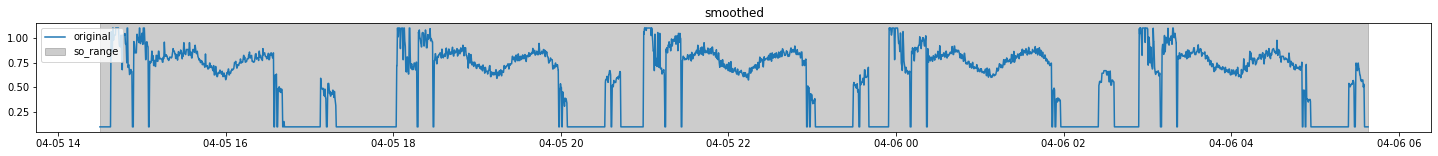

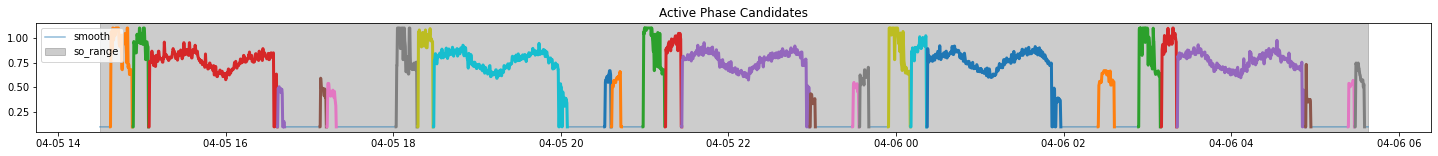

In [94]:
# cleaning + smoothing + inactive phase detection
times_, y_ = cleaning(temp, smooth_factor, min_threshold)
smooth_ = smoothing(y_, step)
times, ss, inactive_cycles_ = inactive_phase_cleaning_normalization(smooth_, times_, upper_limit, window, edit_so_range)

# active phase detection
cycles_ = active_phase(ss, times, threshold, upper_limit, max_cycle * 60, gap, idle_value)
cycles = cycle_generate(cycles_, times, ss, inactive_cycles_, edit_so_range)

# cycle parameter
cycle_parameter = parameter[machine]['cycle']
# cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 else 1000
cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 and machine not in ['SNK RB-200F(2060)'] else 1000
cycle_parameter['min_dist'] = round(max(cycle_parameter['lower_limit'] ** 0.4, 2.8), 1) * 1.3
cycle_parameter['order'] = int(min(max(cycle_parameter['lower_limit'] ** 0.6, 5), 15))
cycle_parameter['gap'] = 50
cycle_parameter['n'] = 5
cycle_parameter['cycle_gap'] = [30, 60][machine not in {"G3020 #1"}]

# quantity_ 장비마다 스핀들 배수 적용
quantity_ = quantityRedefine(machine, quantity_)

# order_number 미사용
patterns, candidates, first_phase, last_phase = pattern_detector(cycles, cycle_parameter, machine, order_number_)
output, complete_cycle = best_cycle(patterns, quantity_)

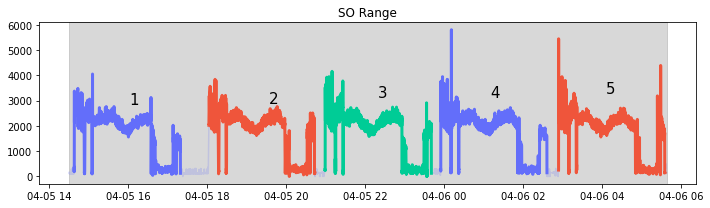

In [131]:
color_lst = ['#636EFA', '#EF553B', '#00CC96']

cycle_idx = 1
ww = [i for i in complete_cycle if i[1] != -1]
plt.figure(figsize=(10,3))
plt.plot(data_.timestamp, data_.value, color='#636EFA', alpha=0.2)
for idx, c in enumerate(ww):
    temp1 = sum(cycles[c[0]:c[1] + 1], [])  # concatenate
    start_, end_ = pd.to_datetime(temp1[0][0]), pd.to_datetime(temp1[-1][0])
    d_ = data_[(data_.timestamp >= start_) & (data_.timestamp < end_)]
    center_idx, max_yy = d_.shape[0]//2, np.quantile(d_.value, 0.98)
    plt.plot(d_.timestamp, d_.value, color=color_lst[idx%len(color_lst)], linewidth=3)
    
    # plt.scatter(d_.timestamp.iloc[center_idx+20], max_yy, marker='o', alpha=0.2, color='black', s=100)
    
    plt.text(d_.timestamp.iloc[center_idx], max_yy, f'{cycle_idx}', fontsize=15)
    cycle_idx += 1
plt.axvspan(edit_so_range[0], edit_so_range[1], alpha=0.3, color='gray')
# plt.axvspan(true_so_range[0], pd.to_datetime('2022-04-27 06:30'), alpha=0.25, color='blue')
plt.title('SO Range')
plt.tight_layout()
plt.show()

In [112]:
quantity = quantity_
# temp = [(i, patterns[i][0], np.mean(patterns[i][1]), gap_size(patterns[i][2]), abs(quantity - len(patterns[i][2])), np.std(patterns[i][-2]), cycle_length(patterns[i][2])) for i in patterns.keys() if len(patterns[i][2]) > 1]
temp = [(i, patterns[i][0], min([j for j in patterns[i][1] if not np.isnan(j)]), gap_size(patterns[i][2]), abs(quantity - len([k for k in patterns[i][2] if k[1] != -1])), np.std(patterns[i][-2]), cycle_length(patterns[i][2])) for i in patterns.keys() if len(patterns[i][2]) > 1]
# order = number of active phase used, diff b/w recorded quantity and # of detected cycles,
#         number of not used active phase, average of distance difference
if quantity == -1: # if no SO mapping with quantity info is available
    temp = sorted(temp, key=lambda xx: [-xx[-1], xx[3], xx[2]])
else:
    temp = sorted(temp, key=lambda xx: [-xx[-1], xx[4], xx[3], xx[2]])
#print(temp[:3])

output, exclude, c, diff, dist = [], set(), 0, float('inf'), float('inf')

visited = set()
for i in range(len(temp)):
    if i not in visited:
        visited.add(temp[i][0])
        output_, exclude_, c_, d_, diff_ = [temp[i][0]], set(patterns[temp[i][0]][2]), temp[i][-1], temp[i][2], temp[i][4]
        temp_ = [i for i in temp if overlapped(exclude_, patterns[i[0]][2]) and i[0] not in visited]
        while len(temp_) > 0:
            if quantity == -1: # if no SO mapping with quantity info is available
                temp = sorted(temp, key=lambda xx: [-xx[-1], xx[3], xx[2]])
            else: # if SO mapping is available, let's look for the one with similar quantity
                temp = sorted(temp, key=lambda xx: [-xx[-1], xx[4], xx[3], xx[2]])
            output_ += [temp_[0][0]]
            c_ += temp_[0][-1]
            d_ += temp_[0][2]
            diff_ += temp_[0][4]
            exclude_ |= set(patterns[temp_[0][0]][2])
            # the rest
            temp_ = [i for i in temp_ if overlapped(exclude_, patterns[i[0]][2]) and i[0] not in visited]
        #print(c_, c, output_, d_, dist)
        if c_ > c:
            output, exclude, c, dist, diff = output_, exclude_, c_, d_, diff_
        elif c_ == c and d_ < dist and diff_ < diff_:
            output, exclude, c, dist, diff = output_, exclude_, c_, d_, diff_
# complete_cycle = []
# for i in output:
#     complete_cycle += patterns[i][2]
# # return output, complete_cycle

In [113]:
print([t[0] for t in temp[:3]])

[37, 38, 107]


In [114]:
len(temp)

103

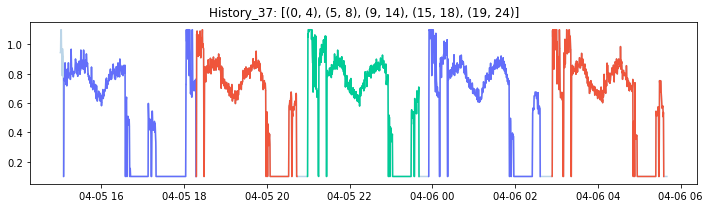

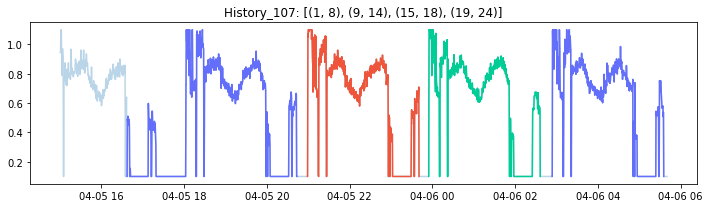

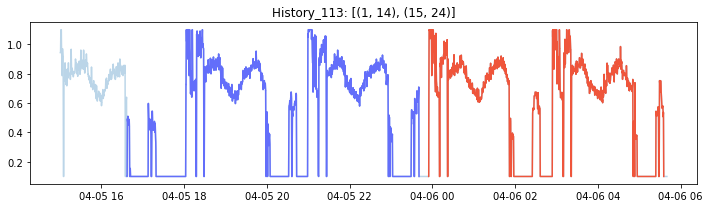

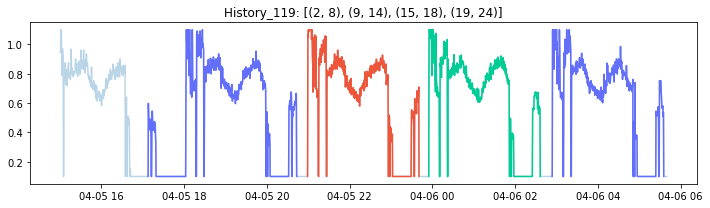

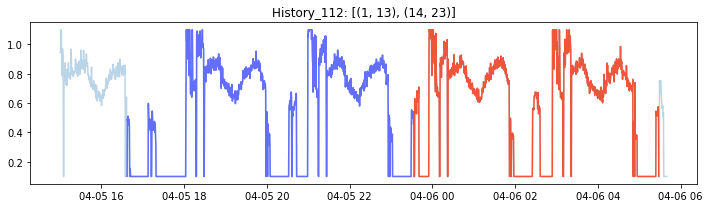

In [115]:
color_lst = ['#636EFA', '#EF553B', '#00CC96']

for t in temp[0:10:2]:
    ww = sorted([cy for cy in patterns[t[0]][2] if cy[1] != -1])
    plt.figure(figsize=(10,3))
    plt.plot(times, ss, alpha=0.3)
    for idx, c in enumerate(ww):
        temp1 = sum(cycles[c[0]:c[1] + 1], [])  # concatenate
        xx_, yy_ = pd.to_datetime([x[0] for x in temp1]), [x[1] for x in temp1]
        plt.plot(xx_, yy_, color=color_lst[idx%len(color_lst)])
    plt.title(f'History_{t[0]}: {ww}')
    plt.tight_layout()

In [102]:
temp

[(37, 8003.898116666666, 0.1300377189023968, 0, 0, 41.44990004523805, 27),
 (38, 8009.547959999999, 0.1300377189023968, 0, 0, 34.29282662801193, 27),
 (97, 8022.52225, 0.1300377189023968, 0, 0, 397.9317287342641, 27),
 (107, 8020.525, 0.3026036956986898, 0, 0, 814.9648970097786, 25),
 (68, 7517.624766666666, 0.1300377189023968, 2, 0, 485.7629263844054, 25),
 (96, 7782.50725, 0.1300377189023968, 3, 0, 363.70721415864176, 24),
 (49, 7158.479399999999, 0.16837294747891002, 3, 0, 549.180296478129, 24),
 (130, 8331.872333333335, 0.1300377189023968, 0, 1, 409.65508443956526, 24),
 (129, 8331.872333333333, 0.15960264127276388, 0, 1, 239.85089389282535, 24),
 (136, 16956.916, 0.10947010338739276, 0, 3, 472.6285000000007, 24),
 (117, 7449.893999999999, 0.1675154575516683, 0, 0, 628.8853502276546, 23),
 (118, 7449.894, 0.44117340035031327, 0, 0, 378.941849863749, 23),
 (106, 7231.5472500000005, 0.16837294747891002, 3, 0, 528.1967162013033, 23),
 (141, 8231.925666666668, 0.15960264127276388, 0, 1